In [1]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error, r2_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm



In [3]:
df = pd.read_excel("finaldata.xlsx")

In [4]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [5]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
TimeStamp,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1.0,1.0,1.0,1.0


In [6]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [7]:
data=data.drop(data[data.index>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26304, 16)

In [8]:
min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00', freq='H')

In [9]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 2019-01-01 00:00:00 2021-05-26 18:00:00 21043
Test: 2021-05-26 19:00:00 2021-12-31 23:00:00 5261


In [10]:
train_df=train_df.drop(columns=['ElectricityPrice'])
test_df=test_df.drop(columns=['ElectricityPrice'])

In [11]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('IE Demand')
exogenous_features

['IE Generation',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = HistGradientBoostingRegressor(),
                lags      = 50,
                transformer_y    = StandardScaler(),
                transformer_exog = StandardScaler()
             )

forecaster.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster

ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 50 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'day', 'month', 'hour', 'dayofweek'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-05-26 18:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 25

In [ ]:
steps = len(test_df)
predictions = forecaster.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_test=test_df['IE Demand']
y_pred=predictions

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 286.35110513341937
MSE: 81996.95541113059
MAE: 206.7019917742035
MAPE: 0.06127273991455864
Max Error: 1516.9782454127653
Explained Variance Score: 0.8021905571624823
R2Score: 0.7871255073438576


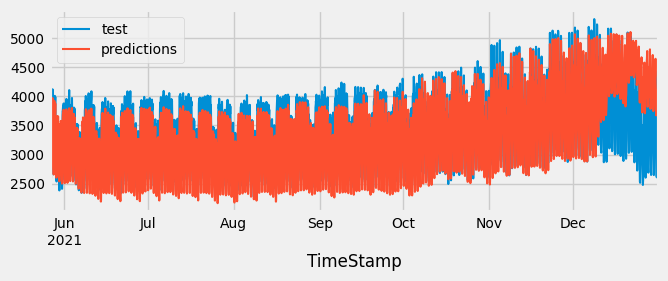

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster2 = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [50, 100,200,350, [1, 2, 3, 25,50]]

# Regressor hyperparameters
param_grid = {
    'learning_rate': [0.1, 0.2]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster2,
                   y                  = train_df['IE Demand'],
                   exog               = train_df.loc[:, train_df.columns != 'IE Demand'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(train_df)-1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 10.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 25 50] 
  Parameters: {'learning_rate': 0.2}
  Backtesting metric: 11.073887614313634



In [ ]:
results_grid

,lags,params,mean_squared_error,learning_rate
9,"[1, 2, 3, 25, 50]",{'learning_rate': 0.2},11.073888,0.2
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},55.067994,0.1
8,"[1, 2, 3, 25, 50]",{'learning_rate': 0.1},59.203233,0.1
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},170.267147,0.2
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},275.515183,0.1
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},438.700011,0.2
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},474.136517,0.1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},1223.326624,0.2
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.1},1508.216046,0.1
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'learning_rate': 0.2},2597.598004,0.2


In [ ]:
predictions2 = forecaster2.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_pred=predictions2

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 170.28478608574176
MSE: 28996.908372266833
MAE: 139.11364771620853
MAPE: 0.04051784072429367
Max Error: 828.007659823415
Explained Variance Score: 0.9485610874475106
R2Score: 0.9247203493423239


In [ ]:
save_forecaster(forecaster2, file_name='HGBDemand.py', verbose=False)

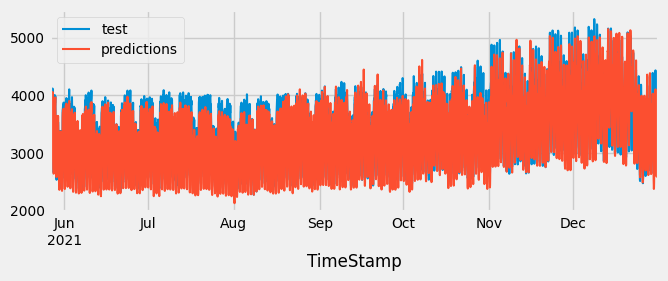

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [ ]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(4319, 17)

In [ ]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(145, 17)

In [ ]:
pred_data=pred_data.drop(columns=['ElectricityPrice'])

In [ ]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [ ]:
last_window = test_df['IE Demand'].tail(50)

In [ ]:
y_pred_hgb = forecaster2.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

In [ ]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [ ]:
pred_ci=forecaster2.predict_interval(steps=145, last_window=last_window, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'])

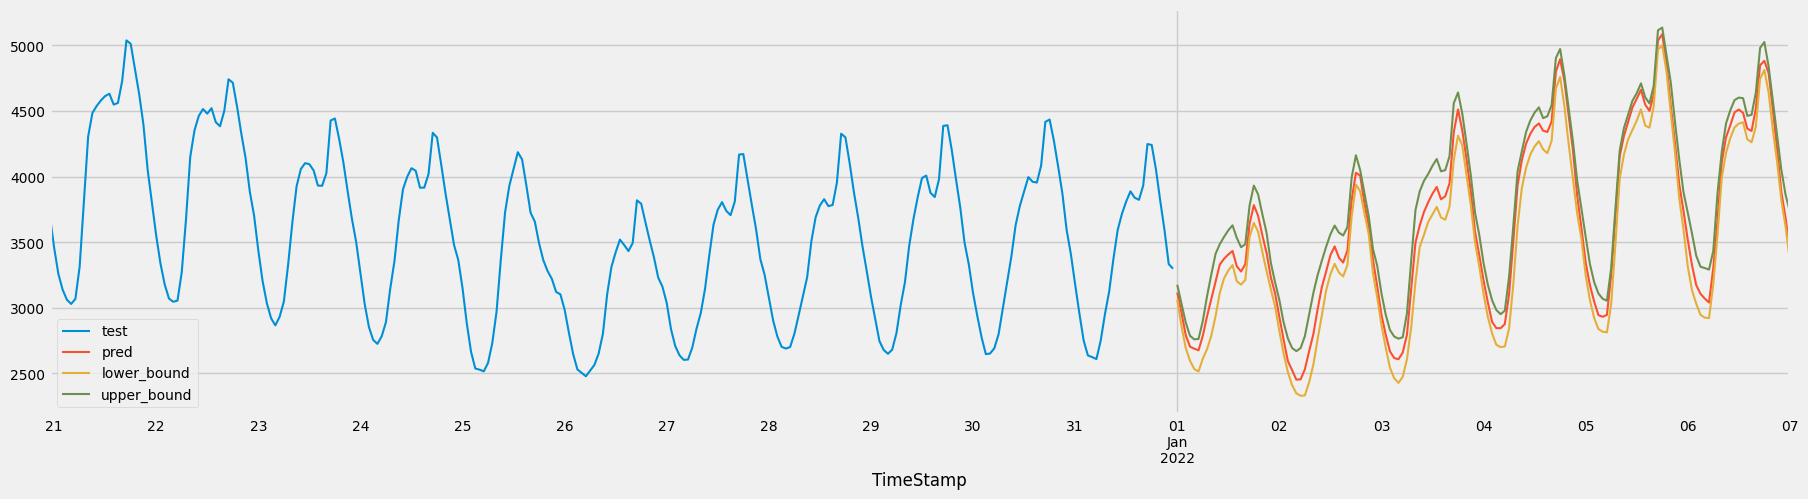

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
#y_pred.plot(ax=ax, label='predictions')
pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()

In [ ]:
forecaster3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10
             )

forecaster3.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster3

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'day', 'month', 'hour', 'dayofweek'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-05-26 18:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_sc

In [ ]:
predictions3 = forecaster3.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_pred=predictions3

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 220.99376022528347
MSE: 48838.242058510084
MAE: 187.07479344231132
MAPE: 0.053741652363633347
Max Error: 849.1294999999982
Explained Variance Score: 0.9331136299979204
R2Score: 0.87320973140654


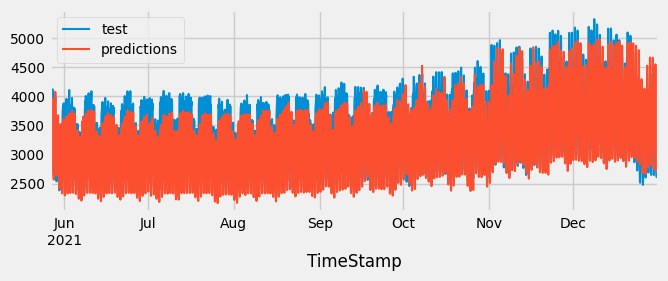

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster4 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10, # Placeholder, the value will be overwritten
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

# Lags used as predictors
lags_grid = [50, 100,200,300, [1, 2, 3, 25,50]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100,250,500],
    'n_jobs':[-1]

}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster4,
                   y                  = train_df['IE Demand'],
                   exog               = train_df.loc[:, train_df.columns != 'IE Demand'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(train_df)-1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 20.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
  Parameters: {'n_estimators': 100, 'n_jobs': -1}
  Backtesting metric: 0.03104643999995795



In [ ]:
results_grid

,lags,params,mean_squared_error,n_estimators,n_jobs
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 100, 'n_jobs': -1}",0.031046,100,-1
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 250, 'n_jobs': -1}",1.976049,250,-1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 500, 'n_jobs': -1}",9.896813,500,-1
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 500, 'n_jobs': -1}",22.352471,500,-1
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 50, 'n_jobs': -1}",26.855197,50,-1
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 250, 'n_jobs': -1}",31.641975,250,-1
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 500, 'n_jobs': -1}",42.768722,500,-1
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 50, 'n_jobs': -1}",47.062344,50,-1
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 50, 'n_jobs': -1}",54.552996,50,-1
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 100, 'n_jobs': -1}",63.784182,100,-1


In [ ]:
predictions4 = forecaster4.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_pred=predictions4

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 387.8638326689447
MSE: 150438.35269264315
MAE: 337.0518285497054
MAPE: 0.09542854688000396
Max Error: 1190.2290999999996
Explained Variance Score: 0.8555948096413882
R2Score: 0.6094429623038772


In [ ]:
save_forecaster(forecaster4, file_name='RFRDemand.py', verbose=False)

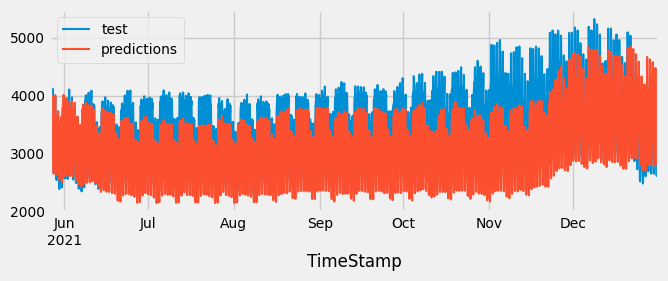

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
last_window = test_df['IE Demand'].tail(50)

In [ ]:
y_pred_rfr = forecaster4.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

In [ ]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [ ]:
pred_ci=forecaster4.predict_interval(steps=145, last_window=last_window, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'])

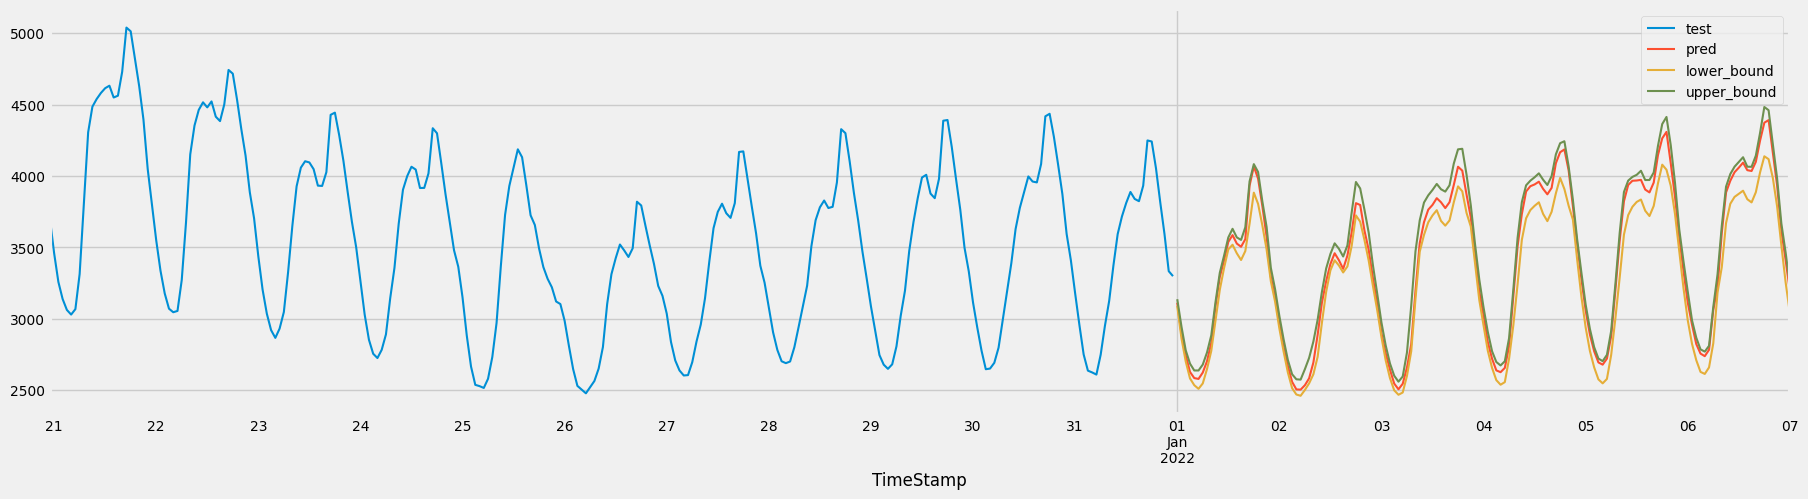

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
#y_pred.plot(ax=ax, label='predictions')
pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()

In [ ]:
forecaster5 = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state = 123),
                 lags      = 50,
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster5.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster5

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardS

In [ ]:
predictions5 = forecaster5.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_pred = predictions5

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 288.2925187778262
MSE: 83112.5763832633
MAE: 211.78874594581202
MAPE: 0.06285549236992141
Max Error: 1469.2676741842579
Explained Variance Score: 0.8001317587946835
R2Score: 0.7842292138504157


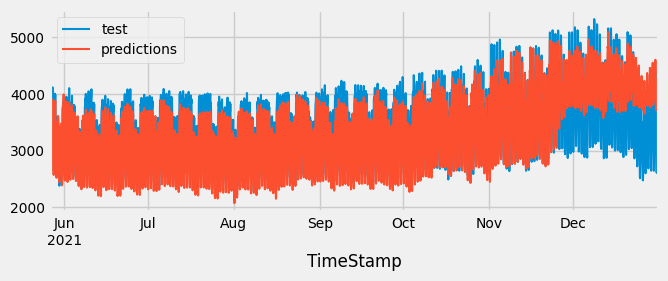

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster6 = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 50,# Placeholder, the value will be overwritten
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

# Lags used as predictors
lags_grid = [50, 100,200,300, [1, 2, 3, 25,50]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100,250,500],
    'learning_rate': [0.1, 0.2]

}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster6,
                   y                  = train_df['IE Demand'],
                   exog               = train_df.loc[:, train_df.columns != 'IE Demand'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(train_df)-1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 40.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 25 50] 
  Parameters: {'learning_rate': 0.1, 'n_estimators': 250}
  Backtesting metric: 0.8266078373983969



In [ ]:
results_grid

,lags,params,mean_squared_error,learning_rate,n_estimators
34,"[1, 2, 3, 25, 50]","{'learning_rate': 0.1, 'n_estimators': 250}",0.826608,0.1,250.0
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.2, 'n_estimators': 50}",1.657091,0.2,50.0
36,"[1, 2, 3, 25, 50]","{'learning_rate': 0.2, 'n_estimators': 50}",4.180205,0.2,50.0
35,"[1, 2, 3, 25, 50]","{'learning_rate': 0.1, 'n_estimators': 500}",21.411270,0.1,500.0
37,"[1, 2, 3, 25, 50]","{'learning_rate': 0.2, 'n_estimators': 100}",22.044489,0.2,100.0
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 100}",53.306628,0.1,100.0
39,"[1, 2, 3, 25, 50]","{'learning_rate': 0.2, 'n_estimators': 500}",72.413636,0.2,500.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 500}",91.679884,0.1,500.0
38,"[1, 2, 3, 25, 50]","{'learning_rate': 0.2, 'n_estimators': 250}",100.436492,0.2,250.0
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 250}",105.085987,0.1,250.0


In [17]:
predictions6 = forecaster6.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [18]:
y_pred=predictions6

In [21]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 154.76049081803703
MSE: 23950.809518239726
MAE: 123.46770143644385
MAPE: 0.03604439001789992
Max Error: 857.9524918207535
Explained Variance Score: 0.9532408994525586
R2Score: 0.9378206617631671


In [ ]:
save_forecaster(forecaster6, file_name='XGBDemand.py', verbose=False)

In [13]:
from joblib import dump, load

In [14]:
forecaster_loaded = load('XGBDemand.py')

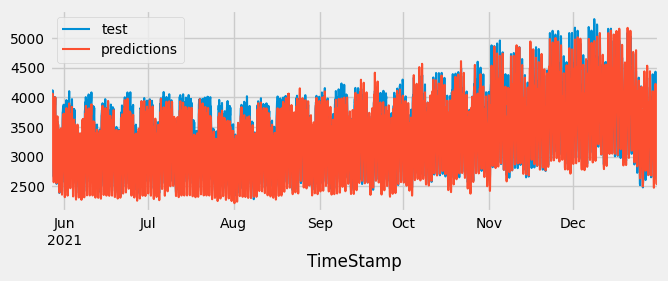

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
last_window = test_df['IE Demand'].tail(50)

In [ ]:
y_pred_xgb = forecaster6.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

In [ ]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [ ]:
pred_ci=forecaster6.predict_interval(steps=145, last_window=last_window, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'])

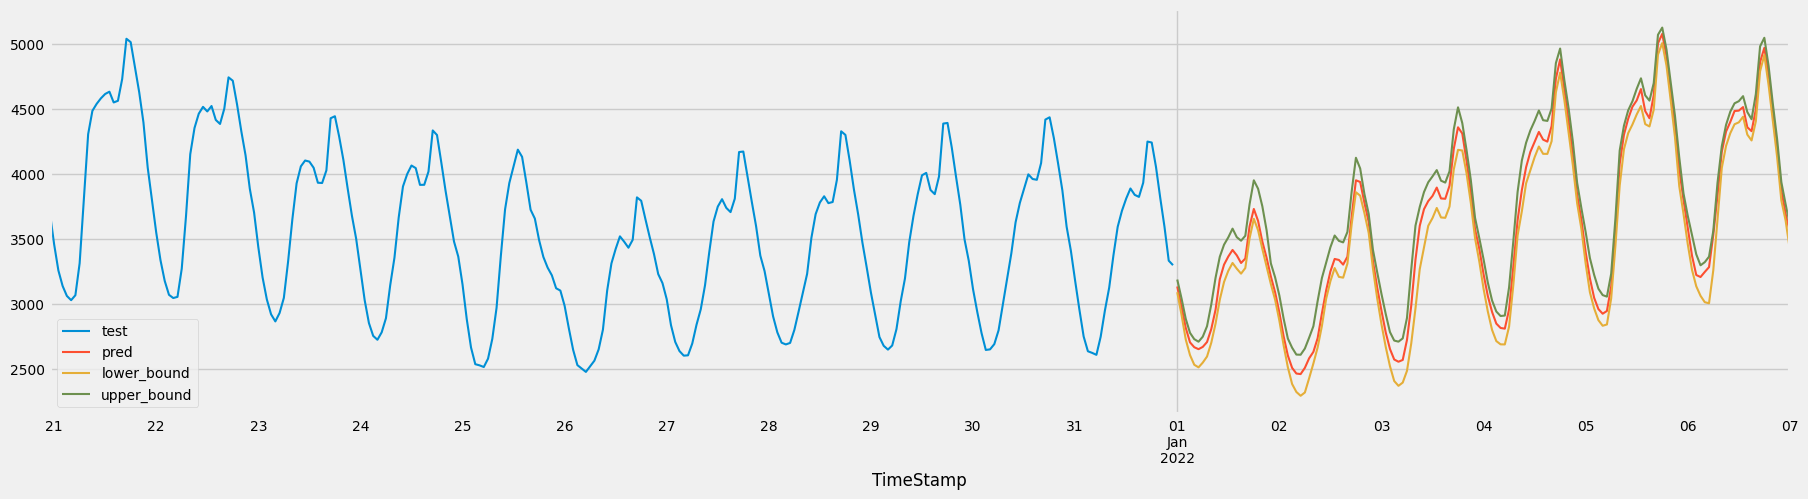

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
#y_pred.plot(ax=ax, label='predictions')
pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()

In [ ]:
r1 = HistGradientBoostingRegressor(random_state=123,learning_rate=0.2)
r2 = RandomForestRegressor(n_estimators=100,random_state=123)
r3 = XGBRegressor(random_state=123,learning_rate=0.1, n_estimators= 250)

In [ ]:
forecaster7 = ForecasterAutoreg(
                 regressor = VotingRegressor([('hg', r1), ('rf', r2), ('xg', r3)]),
                 lags      = [1,2,3,25,50],
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster7.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster7

ForecasterAutoreg 
Regressor: VotingRegressor(estimators=[('hg',
                             HistGradientBoostingRegressor(learning_rate=0.2,
                                                           random_state=123)),
                            ('rf', RandomForestRegressor(random_state=123)),
                            ('xg',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, fea...
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
       

In [ ]:
predictions7 = forecaster7.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [ ]:
y_pred=predictions7

In [ ]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 159.46428985689676
MSE: 25428.859739564385
MAE: 130.79590987416339
MAPE: 0.038033105846773274
Max Error: 616.724211926105
Explained Variance Score: 0.9577425142512213
R2Score: 0.9339834559863527


In [ ]:
save_forecaster(forecaster7, file_name='VRDemand.py', verbose=False)

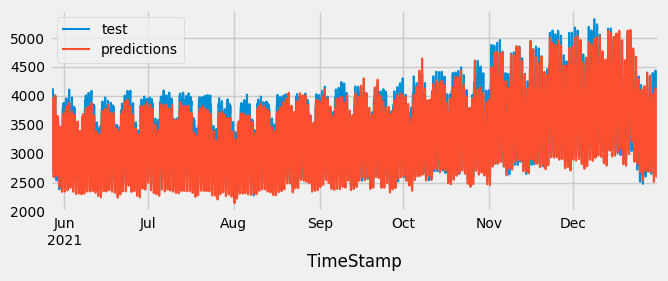

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
y_pred_vr = forecaster7.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

In [ ]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [ ]:
pred_ci=forecaster7.predict_interval(steps=145, last_window=last_window, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'])

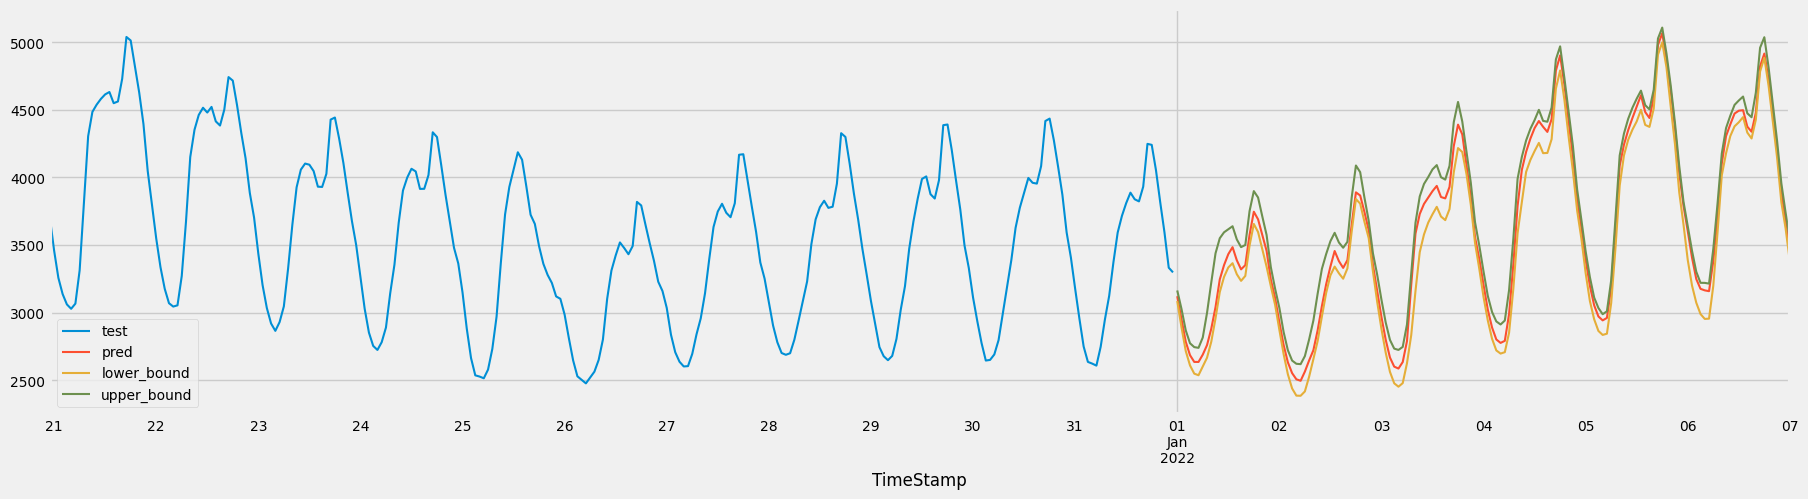

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['IE Demand'].plot(ax=ax, label='test')
#y_pred.plot(ax=ax, label='predictions')
pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()

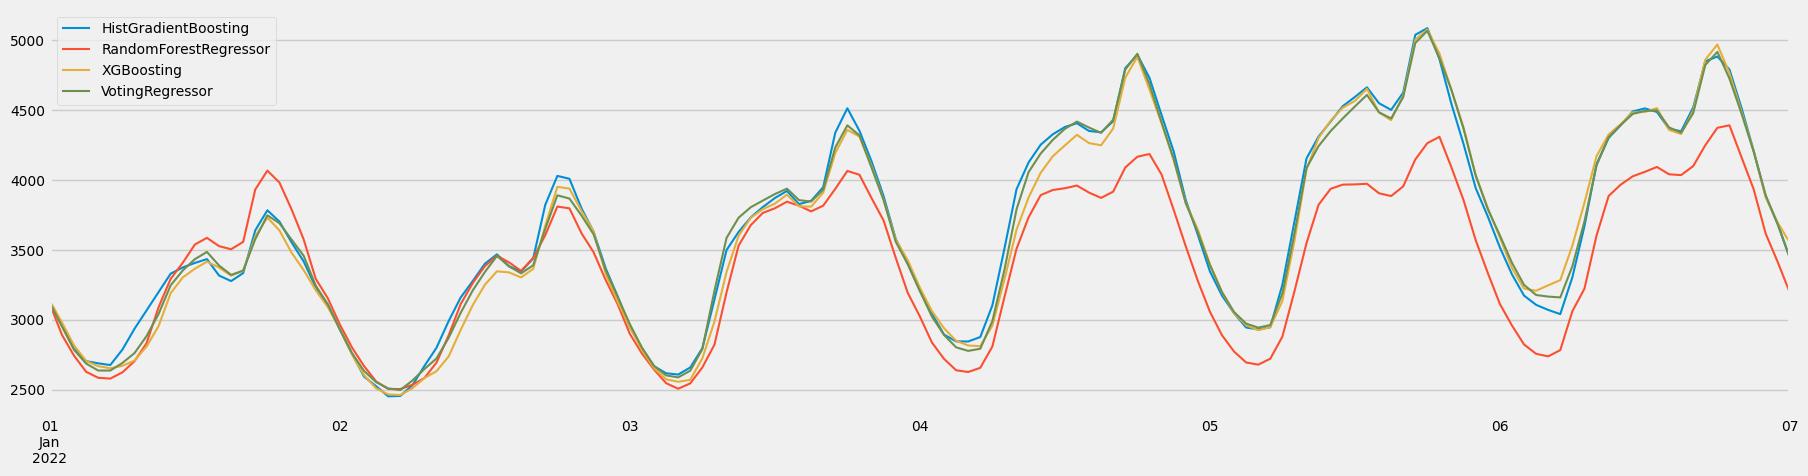

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

y_pred_hgb.plot(ax=ax, label='HistGradientBoosting')
y_pred_rfr.plot(ax=ax, label='RandomForestRegressor')
y_pred_xgb.plot(ax=ax, label='XGBoosting')
y_pred_vr.plot(ax=ax, label='VotingRegressor')
ax.legend();
plt.show()

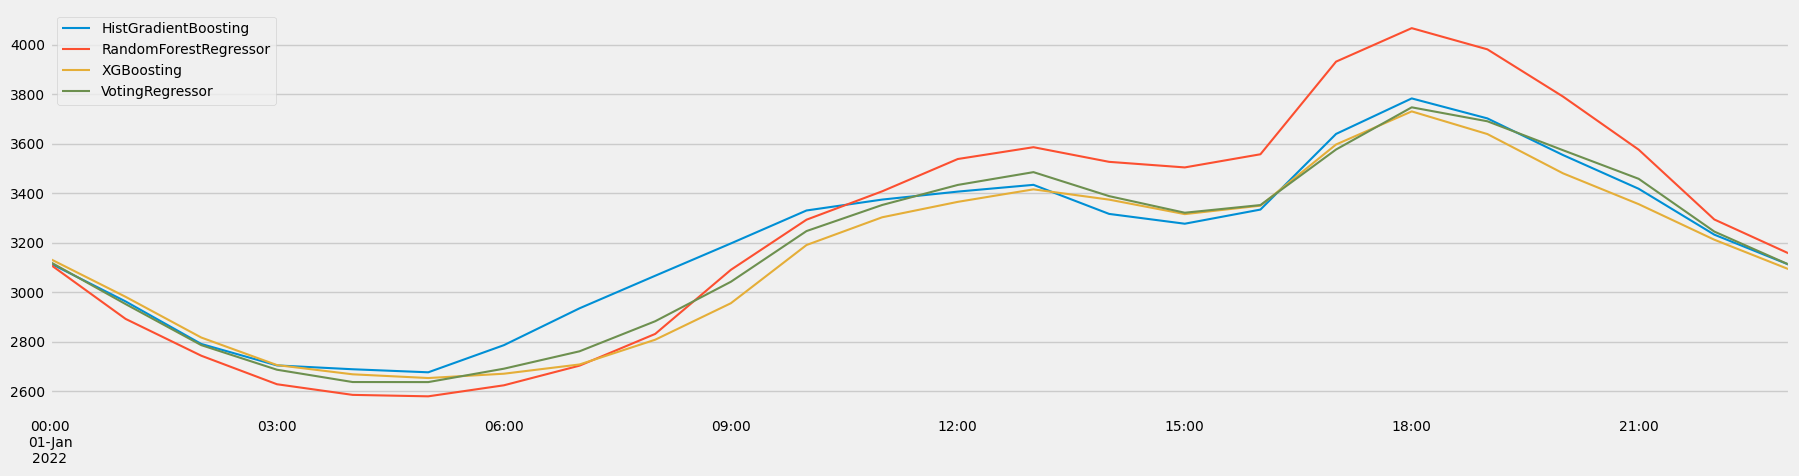

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

y_pred_hgb.head(24).plot(ax=ax, label='HistGradientBoosting')
y_pred_rfr.head(24).plot(ax=ax, label='RandomForestRegressor')
y_pred_xgb.head(24).plot(ax=ax, label='XGBoosting')
y_pred_vr.head(24).plot(ax=ax, label='VotingRegressor')
ax.legend();
plt.show()